In [1]:
from astropy.table import Table, Column
from astropy.time import Time
import astropy.units as u
import bottleneck as bn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from my_progs.vlbi.read_sou import read_sou
from my_progs.catalog.pos_diff import radio_cat_diff_calc

gcfsol = read_sou("../data/gcrf-a1u/gcrf-a1u.sou")
refsol = read_sou("../data/opa2019a/opa2019a.sou")

# Calculate the positional difference
soldif = radio_cat_diff_calc(gcfsol, refsol, sou_name="iers_name")

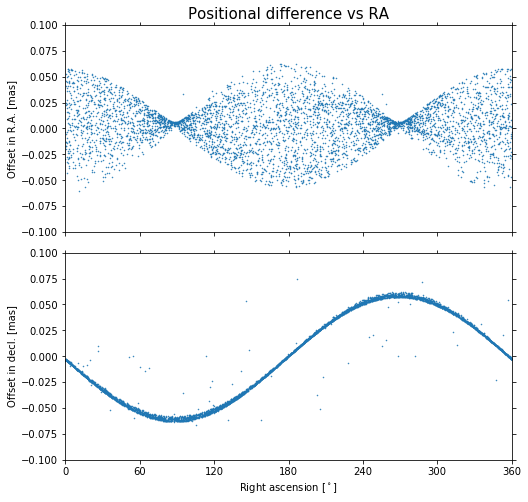

In [4]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(soldif["ra"], soldif["dra"], ".", ms=1)
ax1.plot(soldif["ra"], soldif["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right ascension [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])

ax0.set_title("Positional difference vs RA", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

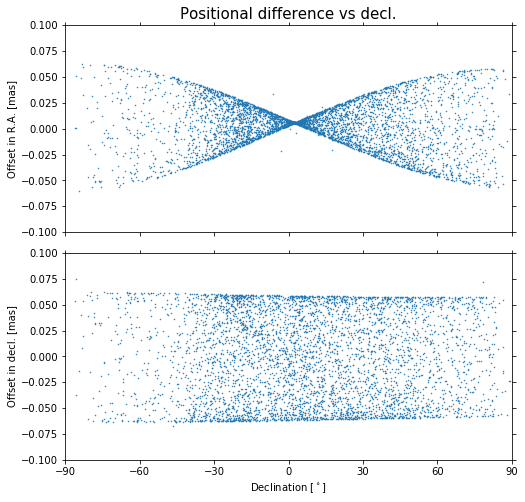

In [5]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.plot(soldif["dec"], soldif["dra"], ".", ms=1)
ax1.plot(soldif["dec"], soldif["ddec"], ".", ms=1)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$^\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.1, 0.1])
ax1.set_ylim([-0.1, 0.1])

ax0.set_title("Positional difference vs decl.", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [6]:
# My modules
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting

# icrf2-ga-19 - icrf3-ga-19
# Transform columns into np.array
dra1 = np.array(soldif["dra"])
ddec1 = np.array(soldif["ddec"])
dra_err1 = np.array(soldif["dra_err"])
ddec_err1 = np.array(soldif["ddec_err"])
ra_rad1 = np.array(soldif["ra"].to(u.radian))
dec_rad1 = np.array(soldif["dec"].to(u.radian))
dra_ddec_cov1 = np.array(soldif["dra_ddec_cov"])

# Transformation parameters
# l_max = 2
par1, sig1, _, _, _, _ = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1,
#     cov=dra_ddec_cov1, elim_flag="None")
         elim_flag="None")

# mas -> uas
par1 = par1 * 1.e3
sig1 = sig1 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "             x             y             z"
      "             x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "        %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size,
       par1[3], sig1[3], par1[4], sig1[4], par1[5], sig1[5],
       par1[0], sig1[0], par1[1], sig1[1], par1[2], sig1[2],))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])

print("Positional difference")
t_quad1 = Table([quad_names, par1[6:], sig1[6:]],
                names=["Quadrupolar term", "Estimate", "Error"])
t_quad1["Estimate"].format = "%5.0f"
t_quad1["Error"].format = "%5.0f"
print(t_quad1)

Estimates (  4600 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
             x             y             z             x             y             z
--------------------------------------------------------------------------------------------
         -60 +/-   0    +2 +/-   0    +6 +/-   0          -0 +/-   0    -3 +/-   0    -1 +/-   0
--------------------------------------------------------------------------------------------

Positional difference
Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -0     0
            EI22       -0     0
            ER21       -0     0
            EI21        0     0
             E20        0     0
            MR22        0     0
            MI22        0     0
            MR21       -0     0
            MI21       -0     0
             M20       -0     0


In [7]:
from my_progs.vlbi.read_eop import read_eob
from my_progs.vlbi.comp_eop import calc_eop_offset

gcfeob = read_eob("../data/gcrf-a1u/gcrf-a1u.eob")
refeob = read_eob("../data/opa2019a/opa2019a.eob")

eoboft = calc_eop_offset(gcfeob, refeob, "../logs/gcrf-a1u_opa2019a_eob_offset.dat")

# Create a Time object for epochs of EOP
eoboft.sort("epoch_pmr")

# which is convenient to convert unit from mjd to jyear
pmrEpoch = Time(eoboft["epoch_pmr"], format="mjd")

nutEpoch = Time(eoboft["epoch_nut"], format="mjd")

There are 6633 and 6633 points in series 1 and series 2, respectively,between which 6633 are common.
Save the EOP offset series in ../logs/gcrf-a1u_opa2019a_eob_offset.dat


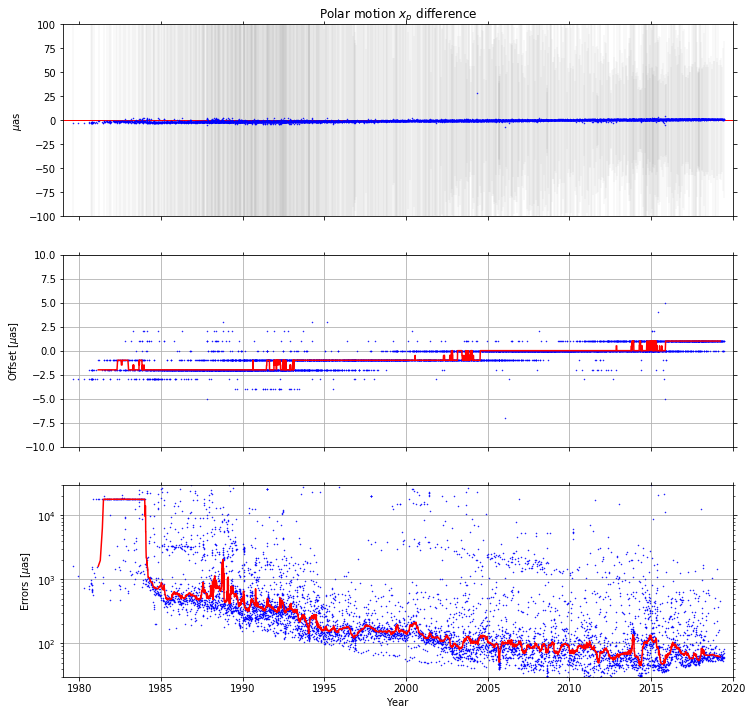

In [8]:
# Polar motion xp
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (12, 12), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dxp"],
            yerr = eoboft["dxp_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dxp"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dxpmed = bn.move_median(eoboft["dxp"], window=50)
ax1.plot(epomed, dxpmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dxp_err"], "b.", ms = 1)
dxperrmed = bn.move_median(eoboft["dxp_err"], window=50)
ax2.plot(epomed, dxperrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)
# ax1.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-10, 10])
ax2.set_ylim([30, 30000])

# Titles and Labels
ax0.set_title("Polar motion $x_p$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

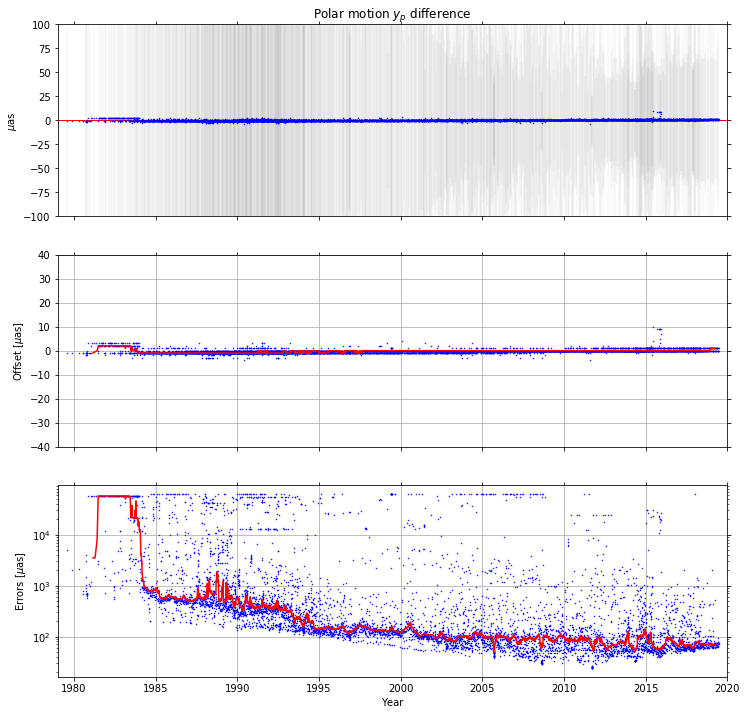

In [9]:
# Polar motion yp
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (12, 12), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dyp"],
            yerr = eoboft["dyp_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dyp"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dypmed = bn.move_median(eoboft["dyp"], window=50)
ax1.plot(epomed, dypmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dyp_err"], "b.", ms = 1)
dyperrmed = bn.move_median(eoboft["dyp_err"], window=50)
ax2.plot(epomed, dyperrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-40, 40])
# ax2.set_ylim([30, 40000])

# Titles and Labels
ax0.set_title("Polar motion $y_p$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

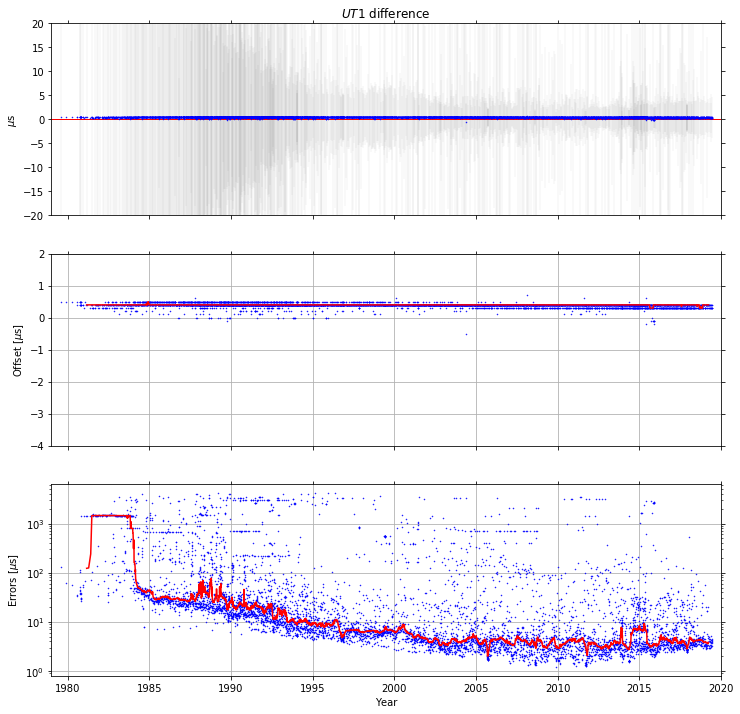

In [10]:
# UT1
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (12, 12), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(pmrEpoch.jyear,
            eoboft["dut"],
            yerr = eoboft["dut_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(pmrEpoch.jyear, eoboft["dut"], "b.", ms = 1)
epomed = bn.move_median(pmrEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["dut"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(pmrEpoch.jyear, eoboft["dut_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["dut_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -20, 20])
ax1.set_ylim([-4, 2])
# ax2.set_ylim([30, 40000])

# Titles and Labels
ax0.set_title("$UT1$ difference")
ax0.set_ylabel("$\mu$s")
ax1.set_ylabel("Offset [$\mu$s]")
ax2.set_ylabel("Errors [$\mu$s]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.5))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

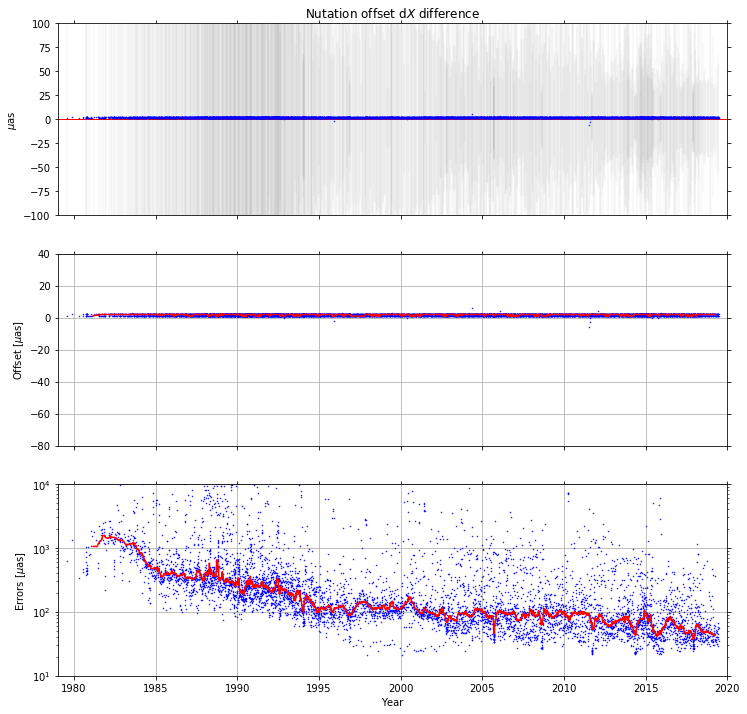

In [11]:
# Nutation offset dX
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (12, 12), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(nutEpoch.jyear,
            eoboft["ddX"],
            yerr = eoboft["ddX_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.05,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(nutEpoch.jyear, eoboft["ddX"], "b.", ms = 1)
epomed = bn.move_median(nutEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["ddX"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(nutEpoch.jyear, eoboft["ddX_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["ddX_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
ax1.set_ylim([-80, 40])
ax2.set_ylim([10, 10000])

# Titles and Labels
ax0.set_title("Nutation offset d$X$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(10))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

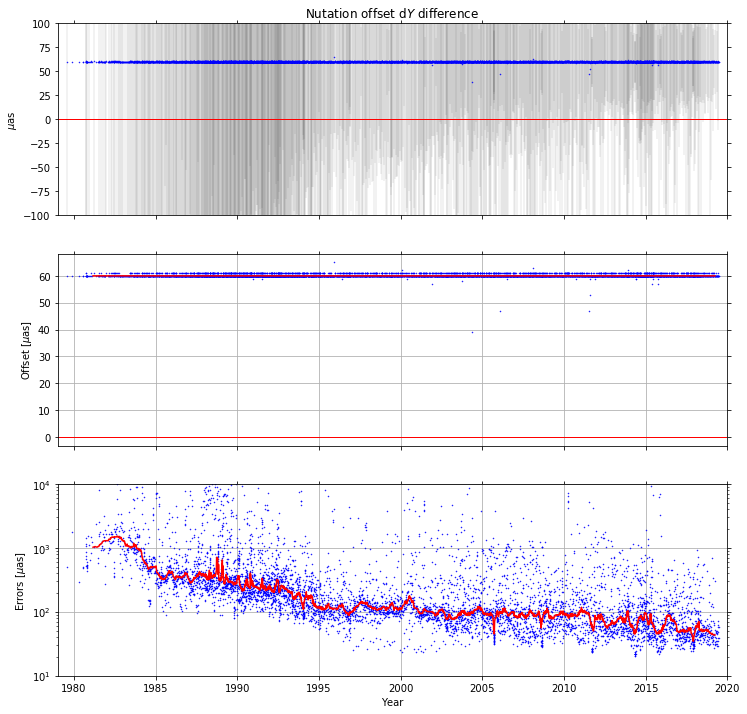

In [12]:
# Nutation offset dY
fig, (ax0, ax1, ax2)=plt.subplots(figsize = (12, 12), sharex = True, nrows=3)

# Error bar plot
ax0.errorbar(nutEpoch.jyear,
            eoboft["ddY"],
            yerr = eoboft["ddY_err"],
            fmt = "b.",
            ms = 1,
            elinewidth = 0.1,
            ecolor = "k",
            errorevery=5)

# Offset
ax1.plot(nutEpoch.jyear, eoboft["ddY"], "b.", ms = 1)
epomed = bn.move_median(nutEpoch.jyear, window=50)
dutmed = bn.move_median(eoboft["ddY"], window=50)
ax1.plot(epomed, dutmed, "r")


# Formal error
ax2.plot(nutEpoch.jyear, eoboft["ddY_err"], "b.", ms = 1)
duterrmed = bn.move_median(eoboft["ddY_err"], window=50)
ax2.plot(epomed, duterrmed, "r")


# Add a horizontal line
x=np.arange(1979, 2021, 0.5)
y0=np.zeros_like(x)
ax0.plot(x, y0, "r", lw = 1)
ax1.plot(x, y0, "r", lw = 1)

# Add a fitted line
# x0 = np.arange(1979, 2021, 1)
# y0 = x0 * 0.2 - 403
# ax.plot(x0, y0, "r", lw=2)

ax2.set_yscale("log")

# Limits
ax0.axis([1979, 2020, -100, 100])
# ax1.set_ylim([-80, -40])
ax2.set_ylim([10, 10000])

# Titles and Labels
ax0.set_title("Nutation offset d$Y$ difference")
ax0.set_ylabel("$\mu$as")
ax1.set_ylabel("Offset [$\mu$as]")
ax2.set_ylabel("Errors [$\mu$as]")
ax2.set_xlabel("Year")

#Ticks
ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")

ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

# Add minor ticks
# ax0.xaxis.set_minor_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(10))

# Add grid
# ax0.grid()
ax1.grid()
ax2.grid()

## Difference in the station position and velocity

No significant difference and global sysmatics was found.

In [13]:
from my_progs.vlbi.read_trf import read_trf
from my_progs.vlbi.comp_trf import calc_trf_offset

# Station position and velocity
trf1 = read_trf("../data/gcrf-a1u/gcrf-a1u")
trf2 = read_trf("../data/opa2019a/opa2019a")

# Calculate the station position differences
trfoft = calc_trf_offset(trf1,  trf2)
trfoft

There are 188 and 188 stations in two sets, respectively, between which 188 are common.


station,xp,yp,zp,dxp,dxp_err,dyp,dyp_err,dzp,dzp_err,dxp_dyp_cov,dxp_dzp_cov,dyp_dzp_cov,xv,yv,zv,dxv,dxv_err,dyv,dyv_err,dzv,dzv_err,dxv_dyv_cov,dxv_dzv_cov,dyv_dzv_cov
,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr,0.001 m / yr
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
AGGO,2765116662.03,-4449233665.52,-3626420645.46,0.25999975204467773,93.56861192729107,-0.22999954223632812,115.47195158132558,-0.25999975204467773,96.34047050954236,-8632.835630574,-6688.717520716,9266.810247618,2.92,-13.67,8.45,-0.020000000000000018,10.19506557114764,0.019999999999999574,12.623270257742247,0.030000000000001137,10.586802727924988,-103.213444536,-80.733994704,111.723100192
AIRA,-3530219644.68,4118797501.99,3344015635.4,0.0,1.7366542545941608,0.0,1.828578136148412,0.0,1.6602867222260136,-2.934261792,-2.5113926239999995,2.6868281399999994,-25.09,-6.78,-16.02,0.0,0.4087077195258244,0.0,0.3790092347159895,0.0,0.4087077195258244,-0.1277958,-0.11692939999999998,0.12314868
ALGOPARK,918034534.99,-4346132316.84,4561971216.21,0.0,0.36769552621700474,0.0,0.7764032457428293,-0.010000228881835938,0.8273149339882605,-0.12504024,0.10342799999999999,-0.513864,-16.11,-3.8,4.0,0.0,0.06929646455628166,0.0,0.08061017305526642,0.0,0.10748023074035522,-0.00039102000000000006,0.000305368,-0.002573208
AUSTINTX,-737794278.5,-5459892554.91,3202989662.05,-0.059999942779541016,14048.896523563692,-0.020000457763671875,14131.246179300677,0.04999971389770508,14120.625435447257,198528.41532199996,-198379.20559060003,-399084.068468,-24.48,-13.56,-36.73,0.0,625.1092646265931,0.0,628.7635924717652,0.0,628.3181151996176,393.045946914,-392.767474944,-790.1271106560001
AZORES,4552169516.65,-2186665847.97,3882780834.28,-0.25,11192.937489185222,0.08999967575073242,8200.420579010446,-0.10000038146972656,10452.445368431734,-34787195.27691307,52179131.15761908,-27000051.15158505,-292.22,-60.68,60.64,-0.009999999999990905,636.5615660546904,0.0,466.3906623078983,0.0,594.432144031596,-112519.93437856801,168763.124807028,-87329.84442588002
BADARY,-838200986.93,3865751562.5,4987670891.29,0.0,0.39456558390209356,0.0,0.6759940828143394,-0.010000228881835938,0.9065108934811539,-0.022938264,-0.08190826200000001,0.38912546000000003,-27.19,0.47,-2.84,0.0,0.13010764773832473,0.0,0.09758073580374356,-0.010000000000000231,0.2036467529817257,0.0018917040000000001,0.000556416,0.002026944
BERMUDA,2307204098.67,-4874226464.04,3394338408.09,-0.23000001907348633,9486.40032661536,-0.25,12371.118807998248,0.04999971389770508,10903.679903991679,-29339346.375198,5068396.957524264,-51663145.58254231,-244.25,-472.44,914.32,-0.009999999999990905,423.39149894394427,-0.009999999999990905,552.2023128455729,0.0,486.7157396263244,-58449.441239,10097.49402144,-102937.20837696
BLKBUTTE,-2306307292.47,-4787914382.23,3515736294.02,0.0,101.54477641907533,0.009999275207519531,206.49356488278272,0.0,146.80809569638862,20192.514191513998,-14102.585110283999,-29041.700098572,-18.66,2.95,-6.68,0.0,4.423660023103041,0.0,8.974599266819661,0.0,6.403559010425374,38.231654688000006,-26.797500927999995,-55.055662207999994


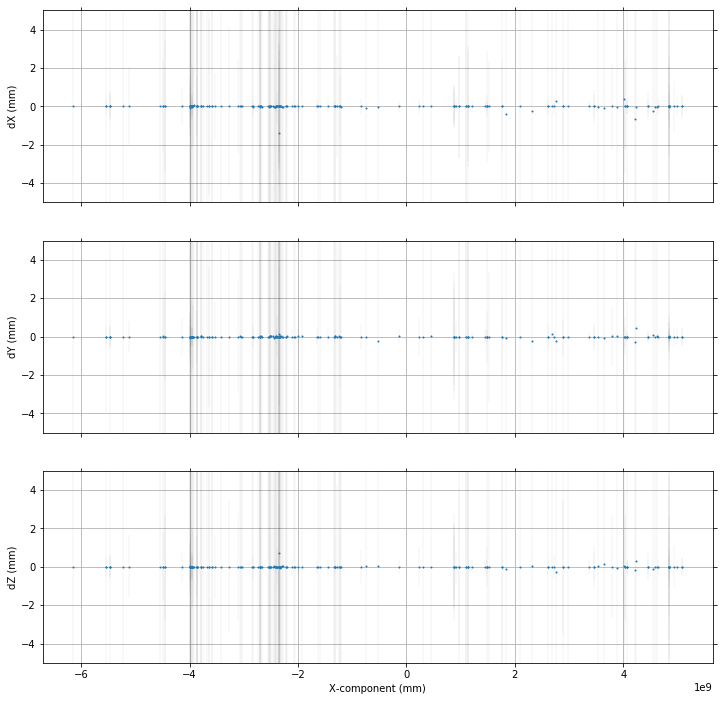

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["xp"], trfoft["dxp"], fmt=".", ms=2,
             yerr=trfoft["dxp_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["xp"], trfoft["dyp"], fmt=".", ms=2,
             yerr=trfoft["dyp_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["xp"], trfoft["dzp"], fmt=".", ms=2,
             yerr=trfoft["dzp_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("X-component (mm)")

ax0.set_ylabel("dX (mm)")
ax1.set_ylabel("dY (mm)")
ax2.set_ylabel("dZ (mm)")

ax0.set_ylim([-5, 5])
ax1.set_ylim([-5, 5])
ax2.set_ylim([-5, 5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

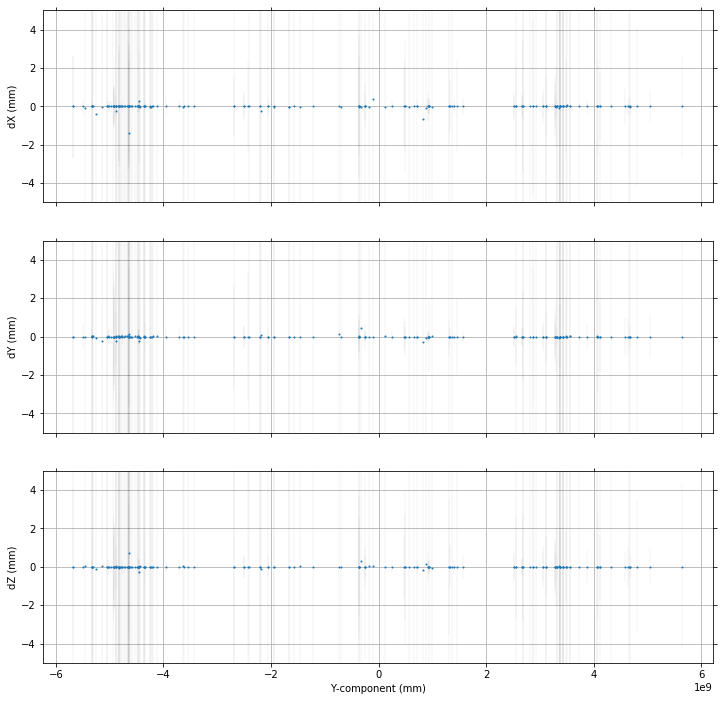

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["yp"], trfoft["dxp"], fmt=".", ms=2,
             yerr=trfoft["dxp_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["yp"], trfoft["dyp"], fmt=".", ms=2,
             yerr=trfoft["dyp_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["yp"], trfoft["dzp"], fmt=".", ms=2,
             yerr=trfoft["dzp_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("Y-component (mm)")

ax0.set_ylabel("dX (mm)")
ax1.set_ylabel("dY (mm)")
ax2.set_ylabel("dZ (mm)")

ax0.set_ylim([-5, 5])
ax1.set_ylim([-5, 5])
ax2.set_ylim([-5, 5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

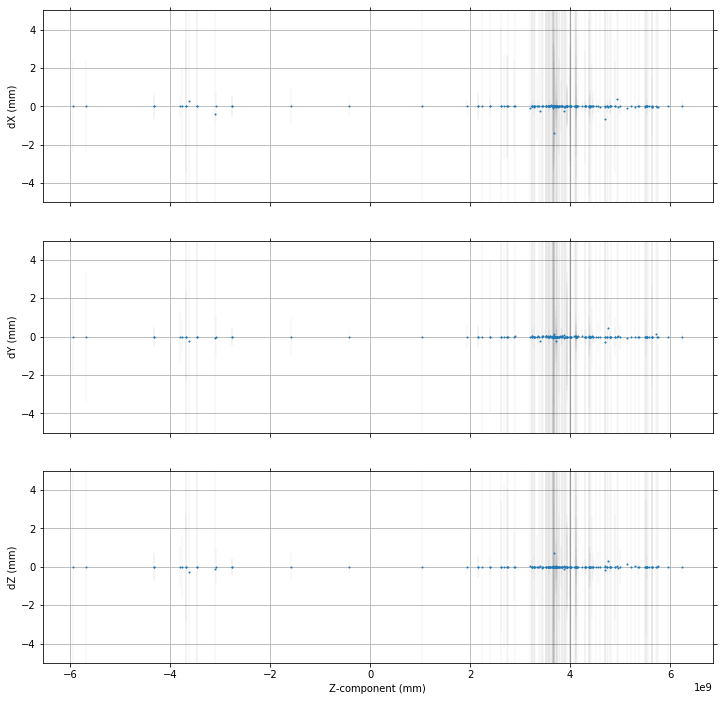

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["zp"], trfoft["dxp"], fmt=".", ms=2,
             yerr=trfoft["dxp_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["zp"], trfoft["dyp"], fmt=".", ms=2,
             yerr=trfoft["dyp_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["zp"], trfoft["dzp"], fmt=".", ms=2,
             yerr=trfoft["dzp_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("Z-component (mm)")

ax0.set_ylabel("dX (mm)")
ax1.set_ylabel("dY (mm)")
ax2.set_ylabel("dZ (mm)")

ax0.set_ylim([-5, 5])
ax1.set_ylim([-5, 5])
ax2.set_ylim([-5, 5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

In [17]:
from my_progs.vlbi.helmert_trans import helmert_trans

dxp = np.array(trfoft["dxp"])
dyp = np.array(trfoft["dyp"])
dzp = np.array(trfoft["dzp"])
dxp_err = np.array(trfoft["dxp_err"])
dyp_err = np.array(trfoft["dyp_err"])
dzp_err = np.array(trfoft["dzp_err"])
xp = np.array(trfoft["xp"])
yp = np.array(trfoft["yp"])
zp = np.array(trfoft["zp"])
xy_cov = np.array(trfoft["dxp_dyp_cov"])
xz_cov = np.array(trfoft["dxp_dzp_cov"])
yz_cov = np.array(trfoft["dyp_dzp_cov"])

helmert_trans(dxp, dyp, dzp, dxp_err, dyp_err, dzp_err,
              xy_cov, xz_cov, yz_cov, xp, yp, zp)

#### Translation component (mm):
    +0.000 +/-    0.072 |   -0.000 +/-    0.076 |   -0.002 +/-    0.069 | =>    0.002 +/-    0.000
#### Scale factor (ppb）:
   -0.000 +/-   0.014
#### Rotation component（mas）:
     -0.000 +/-    0.003 |    -0.000 +/-    0.002 |    +0.000 +/-    0.003 | =>   +0.000 +/-    0.000
##   correlation coefficients are:
 [[ 1.         -0.23196182  0.00662411 -0.0289875  -0.01012452  0.20920752
   0.66156721]
 [-0.23196182  1.          0.07718809  0.086799    0.68233246 -0.0467131
  -0.30213716]
 [ 0.00662411  0.07718809  1.         -0.36294619  0.1696049   0.20600669
   0.00304734]
 [-0.0289875   0.086799   -0.36294619  1.          0.04064929 -0.07566005
  -0.0640213 ]
 [-0.01012452  0.68233246  0.1696049   0.04064929  1.         -0.05407448
   0.02649974]
 [ 0.20920752 -0.0467131   0.20600669 -0.07566005 -0.05407448  1.
   0.12935975]
 [ 0.66156721 -0.30213716  0.00304734 -0.0640213   0.02649974  0.12935975
   1.        ]]


/usr/local/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


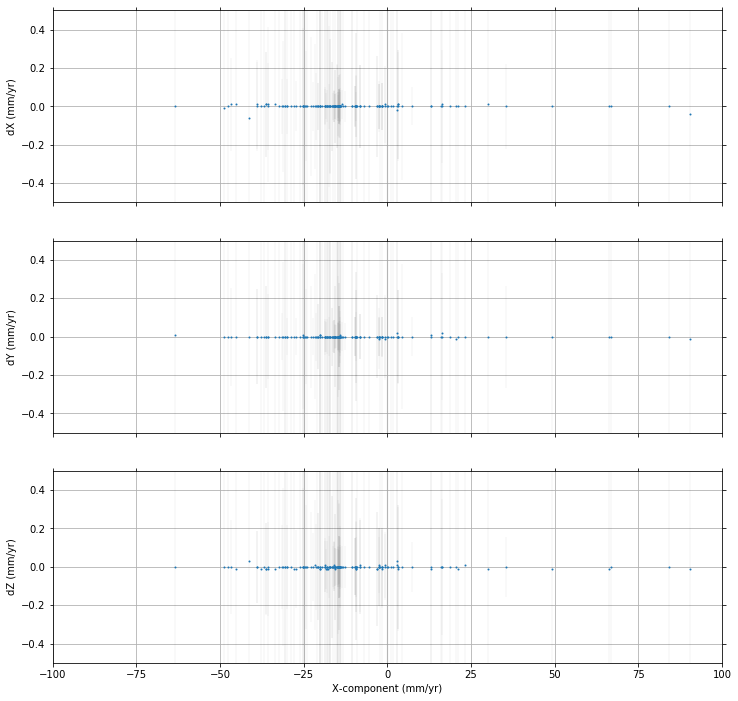

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["xv"], trfoft["dxv"], fmt=".", ms=2,
             yerr=trfoft["dxv_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["xv"], trfoft["dyv"], fmt=".", ms=2,
             yerr=trfoft["dyv_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["xv"], trfoft["dzv"], fmt=".", ms=2,
             yerr=trfoft["dzv_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("X-component (mm/yr)")

ax0.set_ylabel("dX (mm/yr)")
ax1.set_ylabel("dY (mm/yr)")
ax2.set_ylabel("dZ (mm/yr)")

ax0.set_xlim([-100, 100])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])
ax2.set_ylim([-0.5, 0.5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

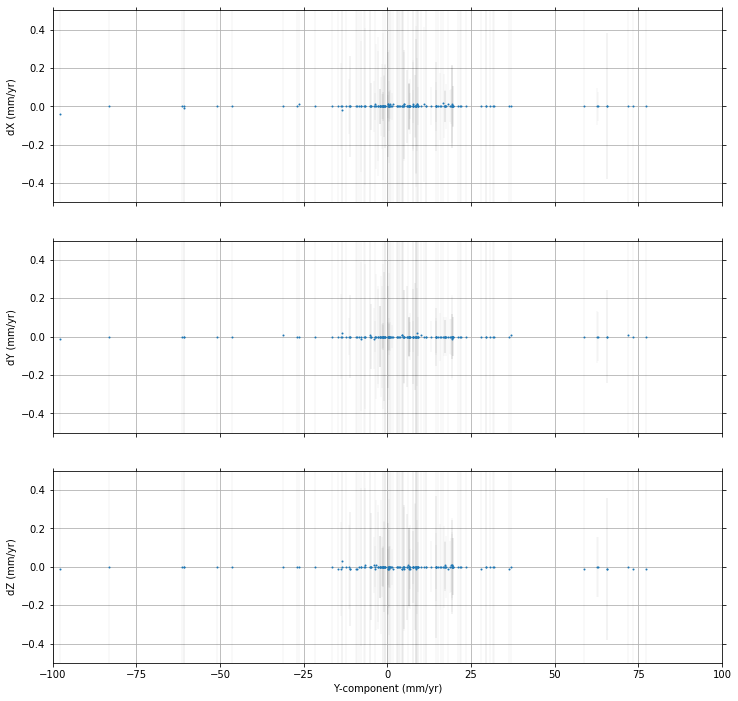

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["yv"], trfoft["dxv"], fmt=".", ms=2,
             yerr=trfoft["dxv_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["yv"], trfoft["dyv"], fmt=".", ms=2,
             yerr=trfoft["dyv_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["yv"], trfoft["dzv"], fmt=".", ms=2,
             yerr=trfoft["dzv_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("Y-component (mm/yr)")

ax0.set_ylabel("dX (mm/yr)")
ax1.set_ylabel("dY (mm/yr)")
ax2.set_ylabel("dZ (mm/yr)")

ax0.set_xlim([-100, 100])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])
ax2.set_ylim([-0.5, 0.5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

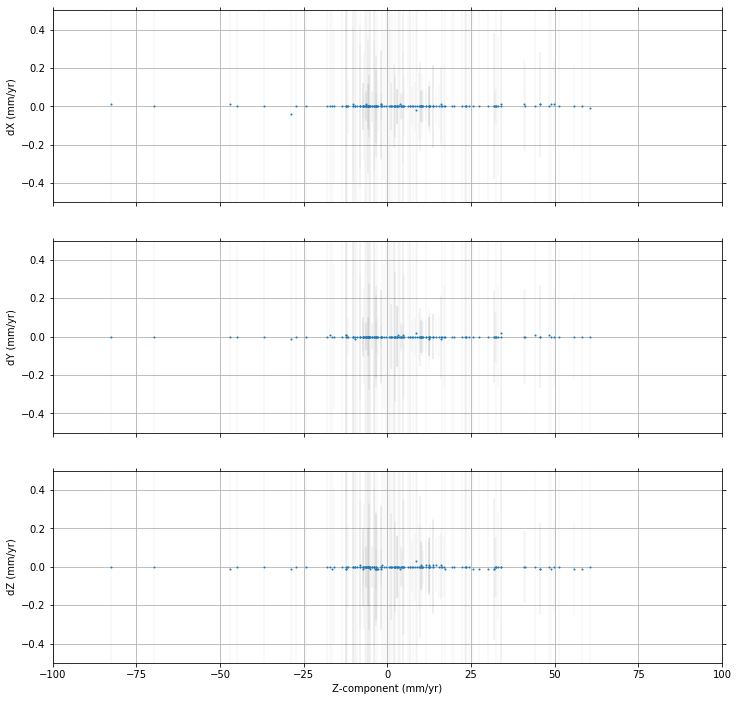

In [20]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax0.errorbar(trfoft["zv"], trfoft["dxv"], fmt=".", ms=2,
             yerr=trfoft["dxv_err"], elinewidth=0.05, ecolor="k")
ax1.errorbar(trfoft["zv"], trfoft["dyv"], fmt=".", ms=2,
             yerr=trfoft["dyv_err"], elinewidth=0.05, ecolor="k")
ax2.errorbar(trfoft["zv"], trfoft["dzv"], fmt=".", ms=2,
             yerr=trfoft["dzv_err"], elinewidth=0.05, ecolor="k")

ax2.set_xlabel("Z-component (mm/yr)")

ax0.set_ylabel("dX (mm/yr)")
ax1.set_ylabel("dY (mm/yr)")
ax2.set_ylabel("dZ (mm/yr)")

ax0.set_xlim([-100, 100])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])
ax2.set_ylim([-0.5, 0.5])

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")
ax2.xaxis.set_ticks_position("both")
ax2.yaxis.set_ticks_position("both")

ax0.grid(True)
ax1.grid(True)
ax2.grid(True)

plt.subplots_adjust()

In [21]:
dxv = np.array(trfoft["dxv"])
dyv = np.array(trfoft["dyv"])
dzv = np.array(trfoft["dzv"])
dxv_err = np.array(trfoft["dxv_err"])
dyv_err = np.array(trfoft["dyv_err"])
dzv_err = np.array(trfoft["dzv_err"])
xy_cov = np.array(trfoft["dxv_dyv_cov"])
xz_cov = np.array(trfoft["dxv_dzv_cov"])
yz_cov = np.array(trfoft["dyv_dzv_cov"])

helmert_trans(dxv, dyv, dzv, dxv_err, dyv_err, dzv_err,
              xy_cov, xz_cov, yz_cov, xp, yp, zp, data_type="v")

#### Translation component (mm/yr):
    -0.002 +/-    0.015 |   +0.002 +/-    0.022 |   -0.004 +/-    0.018 | =>    0.005 +/-    0.000
#### Scale factor (ppb/yr）:
   -0.000 +/-   0.002
#### Rotation component（mas/yr）:
     -0.000 +/-    0.001 |    -0.000 +/-    0.001 |    -0.000 +/-    0.001 | =>   +0.000 +/-    0.000
##   correlation coefficients are:
 [[ 1.00000000e+00 -2.80172301e-02 -1.99404217e-02  4.30886206e-03
   2.58372311e-02 -3.71159348e-03  6.34476091e-01]
 [-2.80172301e-02  1.00000000e+00  3.57369836e-01  9.00384041e-03
   8.63105547e-01  2.93615880e-02  6.90490434e-03]
 [-1.99404217e-02  3.57369836e-01  1.00000000e+00 -8.23008946e-02
   4.50833109e-01  5.22525253e-02 -2.30606751e-02]
 [ 4.30886206e-03  9.00384041e-03 -8.23008946e-02  1.00000000e+00
   8.69896813e-03  8.46585118e-04  4.42685055e-03]
 [ 2.58372311e-02  8.63105547e-01  4.50833109e-01  8.69896813e-03
   1.00000000e+00 -1.11700127e-02  3.29784252e-02]
 [-3.71159348e-03  2.93615880e-02  5.22525253e-02  8.465851